# M3: Time Series Decomposition

## Brenda Buckner

### 11/8/20

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [102]:
df = pd.read_csv('ConstructionTimeSeriesDataV2.csv')
df.head()

,Month,Month-Year,Total Construction,Private Construction,Public Construction
0,1,Jan-02,59516,45273,14243
1,2,Feb-02,58588,44475,14113
2,3,Mar-02,63782,49396,14386
3,4,Apr-02,69504,53283,16221
4,5,May-02,73384,55009,18375


## Public Construction Spending: Linear Approach

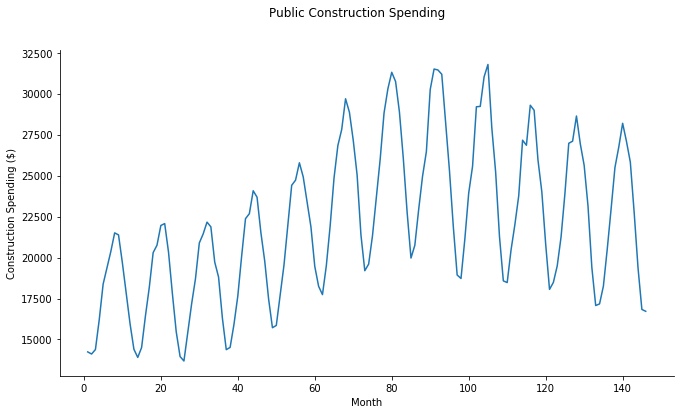

In [151]:
fig,ax = plt.subplots()

ax.plot(df['Month'],df['Public Construction'])
fig.suptitle('Public Construction Spending')
ax.set_xlabel('Month')
ax.set_ylabel('Construction Spending ($)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.set_size_inches(11,6)

In [104]:
from scipy import stats

slope, intercept, r_value, p_value, std_err = stats.linregress(df.index,df['Public Construction'])
print('intercept =', intercept, '    slope =', slope, '     p_value = ',p_value)

intercept = 18327.939893765724     slope = 52.00857586303297      p_value =  3.028349007007645e-09


In [105]:
# create regression column

def create_regress_col(row, intercept, slope):
    return float(intercept) + float(row['Month']) * slope
    
df['Regression'] = df.apply(create_regress_col,args = (intercept,slope),axis = "columns")
df['R1'] = df['Public Construction'] - df['Regression']
df.style.format({
    'Regression': '{:,.0f}'.format,
    'R1': '{:,.0f}'.format
})

,Month,Month-Year,Total Construction,Private Construction,Public Construction,Regression,R1
0,1,Jan-02,59516,45273,14243,"18,380","-4,137"
1,2,Feb-02,58588,44475,14113,"18,432","-4,319"
2,3,Mar-02,63782,49396,14386,"18,484","-4,098"
3,4,Apr-02,69504,53283,16221,"18,536","-2,315"
4,5,May-02,73384,55009,18375,"18,588",-213
5,6,Jun-02,77182,57801,19381,"18,640",741
6,7,Jul-02,78863,58494,20369,"18,692","1,677"
7,8,Aug-02,79460,57953,21507,"18,744","2,763"
8,9,Sep-02,76542,55157,21385,"18,796","2,589"
9,10,Oct-02,75710,56023,19687,"18,848",839


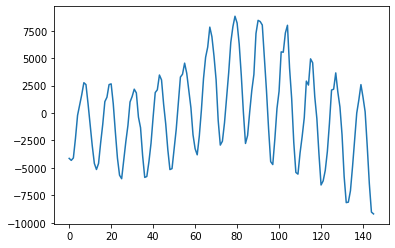

In [106]:
plt.plot(df.index,df.R1)

In [107]:
# Compute autocorrelations - find cyclicality
for i in range(0,20):
    print('autocorrelation, lag =',i,':',df.R1.autocorr(lag = i))

autocorrelation, lag = 0 : 0.9999999999999998
autocorrelation, lag = 1 : 0.8856280681661074
autocorrelation, lag = 2 : 0.6013224790427005
autocorrelation, lag = 3 : 0.2158670848758824
autocorrelation, lag = 4 : -0.16610636997182948
autocorrelation, lag = 5 : -0.42768100297253503
autocorrelation, lag = 6 : -0.5179874711984134
autocorrelation, lag = 7 : -0.41832063408165815
autocorrelation, lag = 8 : -0.15136655336477844
autocorrelation, lag = 9 : 0.21954961123223027
autocorrelation, lag = 10 : 0.5790216579473368
autocorrelation, lag = 11 : 0.8451120068400936
autocorrelation, lag = 12 : 0.9457610635882291
autocorrelation, lag = 13 : 0.8276421035386305
autocorrelation, lag = 14 : 0.5396014613105625
autocorrelation, lag = 15 : 0.14119515861605375
autocorrelation, lag = 16 : -0.24754432310853822
autocorrelation, lag = 17 : -0.5174466437147163
autocorrelation, lag = 18 : -0.615365355385478
autocorrelation, lag = 19 : -0.5192010829679752


In [25]:
# calculate seasonal component using lag 12
dfPeriod = pd.DataFrame()
cycleLen = 12
for i in range(int(len(df.index)/cycleLen)):
    newData = pd.DataFrame({i:df['R1'].iloc[i*cycleLen:(i+1)*cycleLen]})
    newData.index = range(0,len(newData))
    dfPeriod = pd.concat([dfPeriod,newData],axis=1)

avg = []
for i in range(len(dfPeriod.index)):
    avg.append(dfPeriod.iloc[i].mean())

dfPeriod = pd.concat([dfPeriod,pd.DataFrame({'avg':avg})], axis=1)

In [119]:
# add regression model and error to df
df['S'] = np.NaN
df['Public Model'] = np.NaN
df['R2Public'] = np.NaN
df['R2ErrorPublic'] = np.NaN
df['SqErrorPublic'] = np.NaN

S = dfPeriod['avg'].tolist()
for i in df.index:
    df.loc[i,'S'] = S[i%cycleLen]
    df.loc[i,'Public Model'] = df.loc[i,'Regression'] + df.loc[i,'S']
    df.loc[i,'R2Public'] = df.loc[i,'Public Construction'] - df.loc[i,'Public Model']
    df.loc[i,'R2ErrorPublic'] = 100*df.loc[i,'R2Public'] / df.loc[i,'Public Construction']
    df.loc[i,'SqErrorPublic'] = pow(df.loc[i,'R2Public'],2)
df.style.format({
    'Public Model': '{:,.0f}'.format,
    'R2Public': '{:,.0f}'.format,
    'S': '{:,.0f}'.format,
    'R2ErrorPublic': '{:.2f}%'.format,
    'SqErrorPublic': '{:,.0f}'.format
})


,Month,Month-Year,Total Construction,Private Construction,Public Construction,Regression,R1,S,Public Model,R2Public,R2ErrorPublic,SqErrorPublic
0,1,Jan-02,59516,45273,14243,18379.948470,-4136.948470,"-4,915","13,465",778,5.46%,"605,776"
1,2,Feb-02,58588,44475,14113,18431.957045,-4318.957045,"-4,946","13,486",627,4.44%,"392,898"
2,3,Mar-02,63782,49396,14386,18483.965621,-4097.965621,"-3,494","14,990",-604,-4.20%,"365,038"
3,4,Apr-02,69504,53283,16221,18535.974197,-2314.974197,"-1,523","17,013",-792,-4.88%,"627,688"
4,5,May-02,73384,55009,18375,18587.982773,-212.982773,555,"19,143",-768,-4.18%,"589,339"
5,6,Jun-02,77182,57801,19381,18639.991349,741.008651,"3,104","21,744","-2,363",-12.19%,"5,583,457"
6,7,Jul-02,78863,58494,20369,18691.999925,1677.000075,"3,670","22,362","-1,993",-9.78%,"3,972,118"
7,8,Aug-02,79460,57953,21507,18744.008501,2762.991499,"4,916","23,660","-2,153",-10.01%,"4,634,048"
8,9,Sep-02,76542,55157,21385,18796.017077,2588.982923,"4,400","23,196","-1,811",-8.47%,"3,280,689"
9,10,Oct-02,75710,56023,19687,18848.025652,838.974348,"2,239","21,087","-1,400",-7.11%,"1,960,049"


In [123]:
# cumulative sq error
csqPublic = sum(df.SqErrorPublic)
round(csqPublic)

659867060

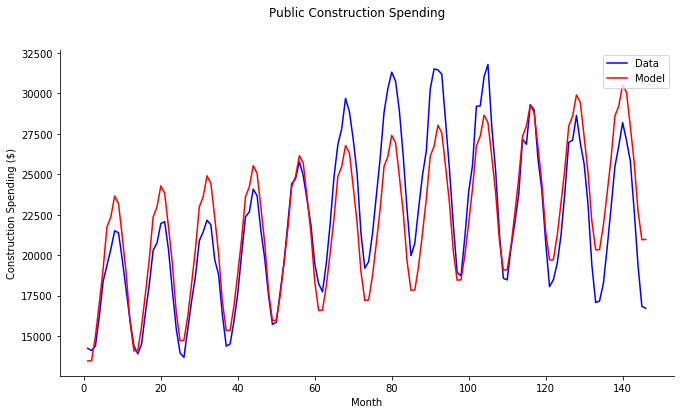

In [152]:
# graph model against original data
fig,ax = plt.subplots()

ax.plot(df['Month'],df['Public Construction'],color='b',label="Data")
ax.plot(df['Month'],df['Public Model'],color='r',label="Model")
ax.legend(loc=1)

fig.suptitle('Public Construction Spending')
ax.set_xlabel('Month')
ax.set_ylabel('Construction Spending ($)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.set_size_inches(11,6)

## Private Construction Spending: Non-Linear Approach

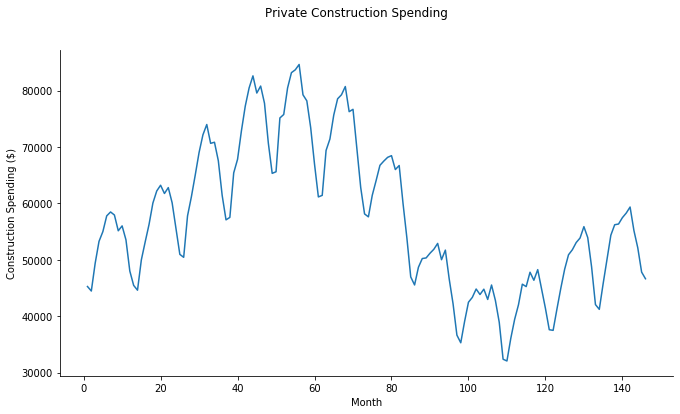

In [153]:
fig,ax = plt.subplots()

ax.plot(df['Month'],df['Private Construction'])
fig.suptitle('Private Construction Spending')
ax.set_xlabel('Month')
ax.set_ylabel('Construction Spending ($)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.set_size_inches(11,6)

Average Squared Error per Month:  35422292.491632506


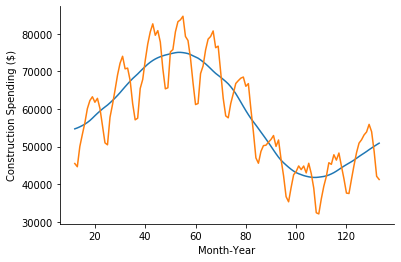

In [130]:
dfPr = pd.read_csv('ConstructionTimeSeriesDataV2.csv')

def sqErr(row):
    return (row['Private Construction'] - row['MovAvg'])**2
    
dfPr['MovAvg'] = np.NaN
dfPr['sqErr'] = np.NaN

window = 24
window = window - window % 2
# Compute the moving average
for i in range(int(window/2),dfPr.shape[0]-int(window/2)):
    dfPr.loc[dfPr.index[i],'MovAvg'] = (0.5*dfPr.iloc[i - int(window/2)]['Private Construction'] + 
                                        dfPr.iloc[i - int(window/2)+1:i + int(window/2)]['Private Construction'].sum() + 
                                        0.5*dfPr.iloc[i + int(window/2)]['Private Construction'])/float(window)

dfPr['sqErr'] = (dfPr['Private Construction'] - dfPr['MovAvg'])**2
dfPr.dropna(how='any',inplace=True)

fig,ax = plt.subplots()
ax.plot(dfPr['MovAvg'],label='Moving Avg.')
ax.plot(dfPr['Private Construction'],label='Private')
ax.set_xlabel('Month-Year')
ax.set_ylabel('Construction Spending ($)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
print('Average Squared Error per Month: ',sum(dfPr['sqErr'])/len(dfPr))

In [131]:
dfPr['R1'] = dfPr['Private Construction'] - dfPr['MovAvg']
dfPr['R1Error'] = abs((dfPr['Private Construction'] - dfPr['R1'])/dfPr['Private Construction'])
dfPr.style.format({
    'MovAvg': '{:.1f}'.format,
    'sqErr': '{:,.1f}'.format,
    'R1': '{:,.1f}'.format,
    'R1Error': '{:,.3f}'.format
})

# check for cyclicality
maxCorr = 0.0
period = np.NaN
for i in range(1,25):
    corr = dfPr['R1'].autocorr(lag=i)
    print('Correlation, lag ',i,'   ',corr)
    if corr > maxCorr:
        maxCorr = corr
        period = i
print('period = ',period,'     Maximum Correlation = ',maxCorr)

Correlation, lag  1     0.8120751333935452
Correlation, lag  2     0.4282692331526067
Correlation, lag  3     -0.02646646398974738
Correlation, lag  4     -0.40983995789979843
Correlation, lag  5     -0.6762655818700407
Correlation, lag  6     -0.8028731553529684
Correlation, lag  7     -0.7018407312644882
Correlation, lag  8     -0.455034007967167
Correlation, lag  9     -0.0816734668578855
Correlation, lag  10     0.36532271423582574
Correlation, lag  11     0.7409089597661687
Correlation, lag  12     0.9315626329218275
Correlation, lag  13     0.7658004796059998
Correlation, lag  14     0.4102417419615045
Correlation, lag  15     -0.02768745747839125
Correlation, lag  16     -0.402710829173791
Correlation, lag  17     -0.6610845035612412
Correlation, lag  18     -0.7864232287415243
Correlation, lag  19     -0.6871128546637586
Correlation, lag  20     -0.453009101761986
Correlation, lag  21     -0.09054074006874907
Correlation, lag  22     0.34563591085831186
Correlation, lag  23    

In [132]:
cycleLen = 12
numCycles = int(len(dfPr)/cycleLen + 0.5)
dfPr['C'] = np.NaN   
for i in range(len(dfPr)):
    dfPr.loc[dfPr.index[i], 'C'] = avg[i % cycleLen] # Write appropriate cyclicality value
dfPr['Private Model'] = dfPr['MovAvg'] + dfPr['C']

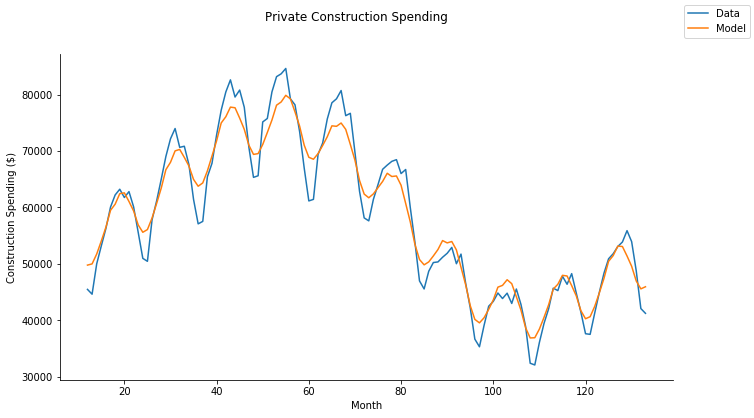

In [154]:
# graph model against original data
fig,ax = plt.subplots()
fig.suptitle('Private Construction Spending')
ax.plot(dfPr['Private Construction'],label='Data')
ax.plot(dfPr['Private Model'],label='Model')

ax.set_xlabel('Month')
ax.set_ylabel('Construction Spending ($)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend(loc = 1)

fig.set_size_inches(11,6)

In [138]:
# add error calculations to dataframe
dfPr['R2Private'] = np.NaN
dfPr['R2ErrorPrivate'] = np.NaN
df['SqErrorPrivate'] = np.NaN

for i in dfPr.index:
    dfPr.loc[i,'R2Private'] = dfPr.loc[i,'Private Construction'] - dfPr.loc[i,'Private Model']
    dfPr.loc[i,'R2ErrorPrivate'] = 100*dfPr.loc[i,'R2Private'] / dfPr.loc[i,'Private Construction']
    dfPr.loc[i,'SqErrorPrivate'] = pow(dfPr.loc[i,'R2Private'],2)
dfPr.style.format({
    'Private Model': '{:,.0f}'.format,
    'R2Private': '{:,.0f}'.format,
    'R2ErrorPrivate': '{:.2f}%'.format,
    'RSqErrorPrivate': '{:,.0f}'.format
})

,Month,Month-Year,Total Construction,Private Construction,Public Construction,MovAvg,sqErr,R1,R1Error,C,Private Model,R2Private,R2ErrorPrivate,SqErrorPrivate
12,13,Jan-03,59877,45473,14404,54694.375000,85033756.890625,-9221.375000,1.202788,-4915.264477,"49,779","-4,306",-9.47%,18542587.839832
13,14,Feb-03,58526,44620,13906,54937.625000,106453385.640625,-10317.625000,1.231233,-4945.773052,"49,992","-5,372",-12.04%,28856793.346376
14,15,Mar-03,64506,49996,14510,55237.083333,27468954.506944,-5241.083333,1.104830,-3493.781628,"51,743","-1,747",-3.49%,3053063.248360
15,16,Apr-03,69638,53195,16444,55576.541667,5671740.710069,-2381.541667,1.044770,-1522.706871,"54,054",-859,-1.61%,737597.206515
16,17,May-03,74473,56286,18187,55949.708333,113092.085069,336.291667,0.994025,554.701220,"56,504",-218,-0.39%,47702.732969
17,18,Jun-03,80377,60076,20301,56392.541667,13567865.293403,3683.458333,0.938687,3103.942644,"59,496",580,0.96%,335838.434072
18,19,Jul-03,82971,62216,20755,56911.583333,28136836.173611,5304.416667,0.914742,3670.017402,"60,582","1,634",2.63%,2671260.957761
19,20,Aug-03,85191,63234,21957,57530.833333,32526110.027778,5703.166667,0.909809,4915.675492,"62,447",787,1.25%,620142.349595
20,21,Sep-03,83841,61767,22075,58188.187500,12807898.910156,3578.812500,0.942059,4400.250250,"62,588",-821,-1.33%,674759.976862
21,22,Oct-03,83133,62813,20321,58820.229167,15942218.927517,3992.770833,0.936434,2238.991674,"61,059","1,754",2.79%,3075741.339792


In [140]:
# cumulative sq error
csqPriv = sum(dfPr.SqErrorPrivate)
round(csqPriv)

1153700307